### Image-to-Line-Drawings

In [ ]:
import numpy as np
import torch
import torch.nn as nn
from PIL import Image
import torchvision.transforms as transforms

In [ ]:
norm_layer = nn.InstanceNorm2d

class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()

        conv_block = [
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_features, in_features, 3),
            norm_layer(in_features),
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_features, in_features, 3),
            norm_layer(in_features)
        ]

        self.conv_block = nn.Sequential(*conv_block)

    def forward(self, x):
        return x + self.conv_block(x)


class Generator(nn.Module):
    def __init__(self, input_nc, output_nc, n_residual_blocks=9, sigmoid=True):
        super(Generator, self).__init__()

        # Initial convolution block
        model0 = [
            nn.ReflectionPad2d(3),
            nn.Conv2d(input_nc, 64, 7),
            norm_layer(64),
            nn.ReLU(inplace=True)
        ]
        self.model0 = nn.Sequential(*model0)

        # Downsampling
        model1 = []
        in_features = 64
        out_features = in_features*2
        for _ in range(2):
            model1 += [  nn.Conv2d(in_features, out_features, 3, stride=2, padding=1),
                        norm_layer(out_features),
                        nn.ReLU(inplace=True) ]
            in_features = out_features
            out_features = in_features*2
        self.model1 = nn.Sequential(*model1)

        model2 = []
        # Residual blocks
        for _ in range(n_residual_blocks):
            model2 += [ResidualBlock(in_features)]
        self.model2 = nn.Sequential(*model2)

        # Upsampling
        model3 = []
        out_features = in_features//2
        for _ in range(2):
            model3 += [
                nn.ConvTranspose2d(in_features, out_features, 3, stride=2, padding=1, output_padding=1),
                norm_layer(out_features),
                nn.ReLU(inplace=True)
            ]
            in_features = out_features
            out_features = in_features//2
        self.model3 = nn.Sequential(*model3)

        # Output layer
        model4 = [
            nn.ReflectionPad2d(3),
            nn.Conv2d(64, output_nc, 7)
        ]
        if sigmoid:
            model4 += [nn.Sigmoid()]

        self.model4 = nn.Sequential(*model4)

    def forward(self, x, cond=None):
        out = self.model0(x)
        out = self.model1(out)
        out = self.model2(out)
        out = self.model3(out)
        out = self.model4(out)

        return out

In [ ]:
# model from https://huggingface.co/spaces/awacke1/Image-to-Line-Drawings
model1 = Generator(3, 1, 3)
model1.load_state_dict(torch.load('model.pth', map_location=torch.device('cpu')))
model1.eval()

Generator(
  (model0): Sequential(
    (0): ReflectionPad2d((3, 3, 3, 3))
    (1): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1))
    (2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (3): ReLU(inplace=True)
  )
  (model1): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (2): ReLU(inplace=True)
    (3): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (5): ReLU(inplace=True)
  )
  (model2): Sequential(
    (0): ResidualBlock(
      (conv_block): Sequential(
        (0): ReflectionPad2d((1, 1, 1, 1))
        (1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
        (2): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (3): ReLU(inplace=Tr

In [ ]:
def predict(input_img):
    input_img = Image.open(input_img)
    input_img = input_img.convert('RGB')
    transform = transforms.Compose([transforms.Resize(256, Image.BICUBIC), transforms.ToTensor()])
    input_img = transform(input_img)
    input_img = torch.unsqueeze(input_img, 0)

    drawing = 0
    with torch.no_grad():
        drawing = model1(input_img)[0].detach()

    drawing = transforms.ToPILImage()(drawing)
    return drawing

In [ ]:
!mkdir /content/AbsKids
!mkdir /content/AbsKids/Img2LineKids

In [ ]:
!unzip /content/AbsKids.zip -d /content/AbsKids/

In [ ]:
!mkdir /content/AbsKidsText
!mkdir /content/AbsKidsText/Img2LineKidsText

In [ ]:
!unzip /content/AbsKidsText.zip -d /content/AbsKidsText/

In [ ]:
!mkdir /content/AbsOther
!mkdir /content/AbsOther/Img2LineOther

In [ ]:
!unzip /content/AbsOther.zip -d /content/AbsOther/

In [ ]:
import sys
import os
from tqdm import tqdm

In [ ]:
# make array with pathes of all files in /content/AbsKids
# /content/AbsKids/Kids/
# /content/AbsKidsText/Kids with text/
# /content/AbsOther/Other/
pathes = []
for root, dirs, files in os.walk("/content/AbsOther/Other/"):
    for name in files:
        pathes.append(os.path.join(root, name))

In [ ]:
len(pathes)

47

In [ ]:
def resize_and_compose_images(image_path, output_path):
    image2 = predict(image_path)

    # return image2

    # Save the result image
    image2.save(output_path)

In [ ]:
path = pathes[2]
resize_and_compose_images(path, f"/content/AbsOther/Img2LineOther/{1}.png")

In [ ]:
path = pathes[0]
resize_and_compose_images(path, f"/content/AbsOther/Img2LineOther/{1}.png")

In [ ]:
# /content/AbsKids/Img2LineKids/
# /content/AbsKidsText/Img2LineKidsText/
# /content/AbsOther/Img2LineOther/

for i, path in tqdm(enumerate(pathes)):
    img_name = path.split('/')[-1]
    resize_and_compose_images(path, f"/content/AbsOther/Img2LineOther/{img_name}")

47it [00:19,  2.44it/s]


In [ ]:
!zip -r /content/AbsKidsTransformed.zip /content/AbsKids/

!zip -r /content/AbsKidsTextTransformed.zip /content/AbsKidsText/

!zip -r /content/AbsOtherTransformed.zip /content/AbsOther/

In [ ]:
!cp /content/AbsKidsTransformed.zip /content/drive/MyDrive/datasets
!cp /content/AbsKidsTextTransformed.zip /content/drive/MyDrive/datasets
!cp /content/AbsOtherTransformed.zip /content/drive/MyDrive/datasets

### Instruct Pix2Pix

In [ ]:
!pip install transformers accelerate torch

In [ ]:
!pip install git+https://github.com/huggingface/diffusers.git

In [ ]:
!cp /content/drive/MyDrive/datasets/AbsKidsTransformed.zip /content/

In [ ]:
!mkdir /content/AbsKids

In [ ]:
!unzip /content/AbsKidsTransformed.zip -d /content/AbsKids/

In [ ]:
!cp /content/drive/MyDrive/datasets/AbsKidsTextTransformed.zip /content/
!cp /content/drive/MyDrive/datasets/AbsOtherTransformed.zip /content/

In [ ]:
!mkdir /content/AbsKidsText
!mkdir /content/AbsOther

In [ ]:
!unzip /content/drive/MyDrive/datasets/AbsKidsTextTransformed.zip -d /content/AbsKidsText
!unzip /content/drive/MyDrive/datasets/AbsOtherTransformed.zip -d /content/AbsOther

In [ ]:
import torch
from diffusers import StableDiffusionInstructPix2PixPipeline, EulerAncestralDiscreteScheduler
import os, sys

In [ ]:
model_id = "timbrooks/instruct-pix2pix"
pipe = StableDiffusionInstructPix2PixPipeline.from_pretrained(model_id, torch_dtype=torch.float16, safety_checker=None)
pipe.to("cuda")
pipe.scheduler = EulerAncestralDiscreteScheduler.from_config(pipe.scheduler.config)

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

In [ ]:
# !cp /content/drive/MyDrive/datasets/AbsKidsImg2Line.zip /content/
# !cp /content/drive/MyDrive/datasets/AbsKidsTextImg2Line.zip /content/
# !cp /content/drive/MyDrive/datasets/AbsOtherImg2Line.zip /content/

In [ ]:
# !unzip /content/AbsKidsImg2Line.zip -d /content/AbsKids/
# !unzip /content/AbsKidsTextImg2Line.zip -d /content/AbsKidsText/
# !unzip /content/AbsOtherImg2Line.zip -d /content/AbsOther/

In [ ]:
# !mkdir /content/AbsKids/InstuctPix2PixKids
# !mkdir /content/AbsKidsText/InstuctPix2PixKidsText
# !mkdir /content/AbsOther/InstuctPix2PixOther

In [ ]:
from PIL import Image

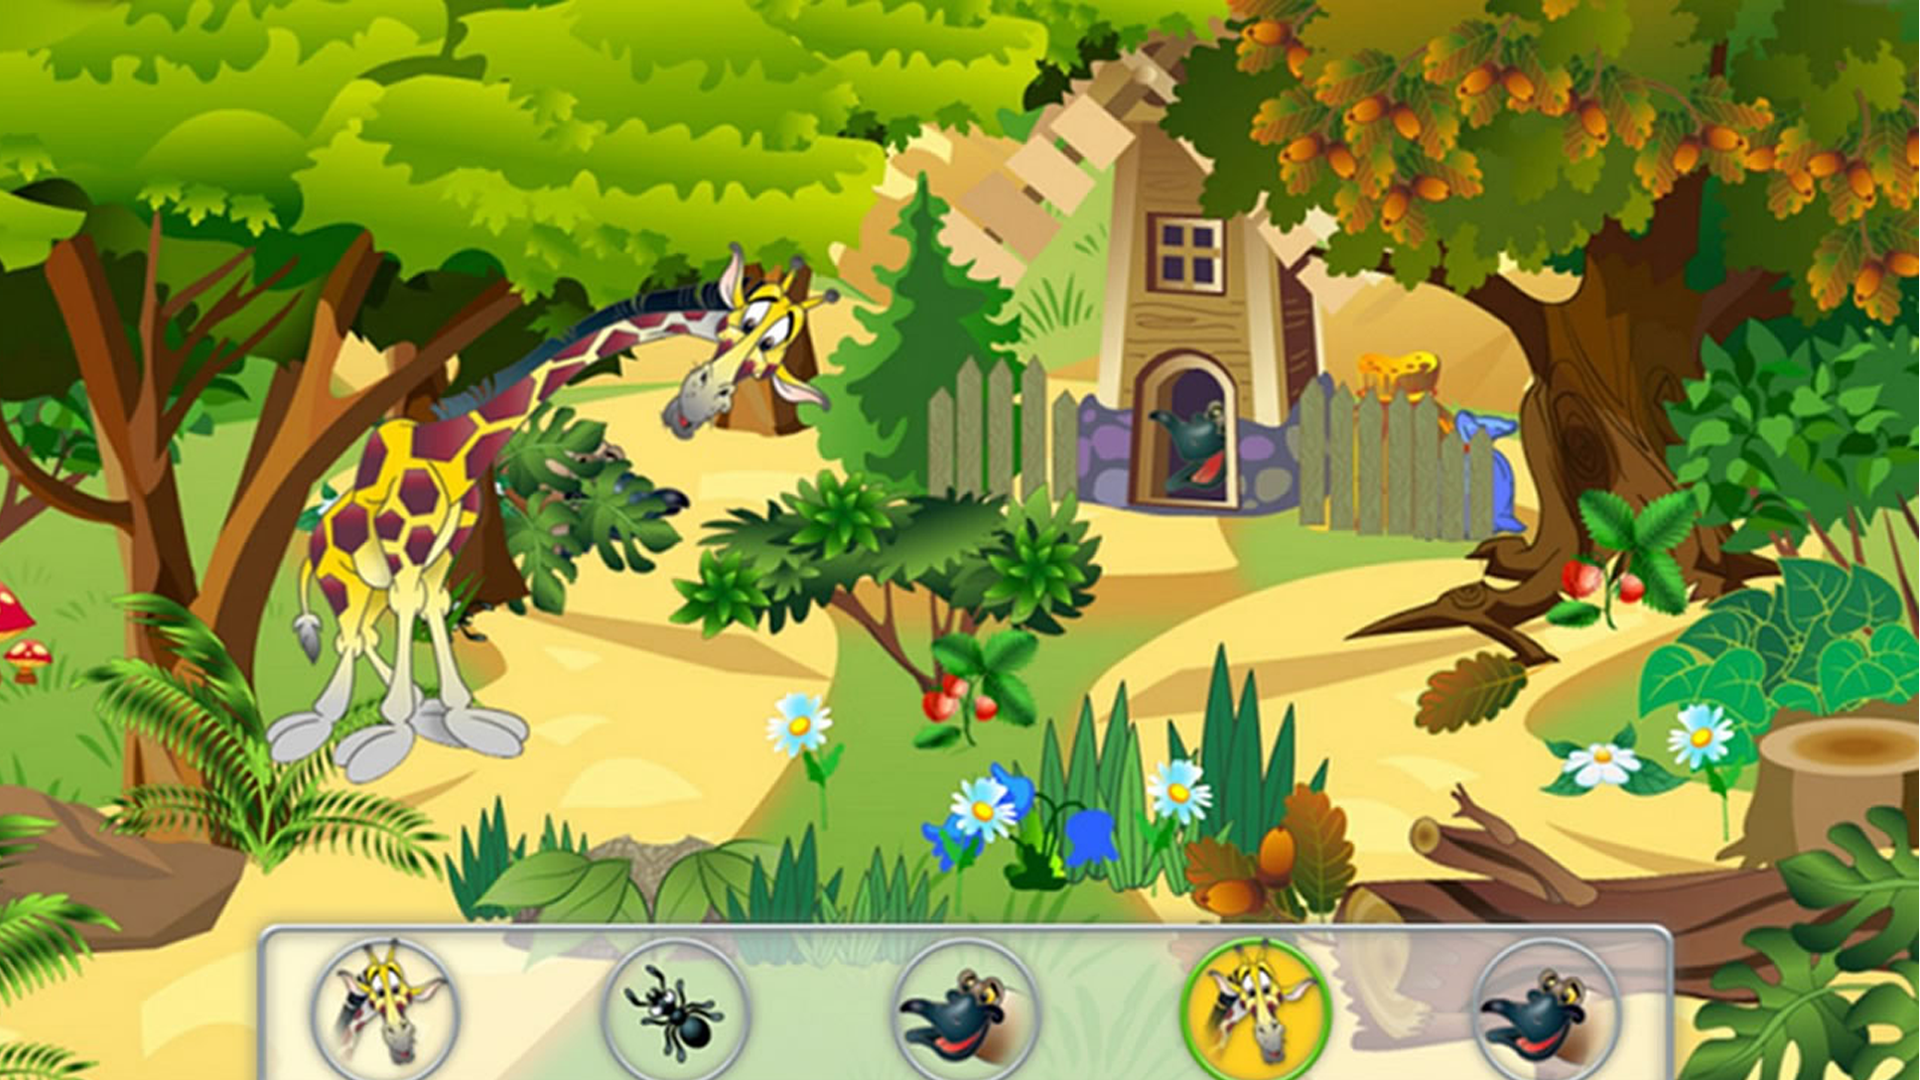

In [ ]:
img = Image.open("/content/AbsKids/content/AbsKids/Kids/04.png")
img

<ipython-input-3-49c4a34c4b79>:11: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  resized_img = img.resize(new_size, Image.ANTIALIAS)


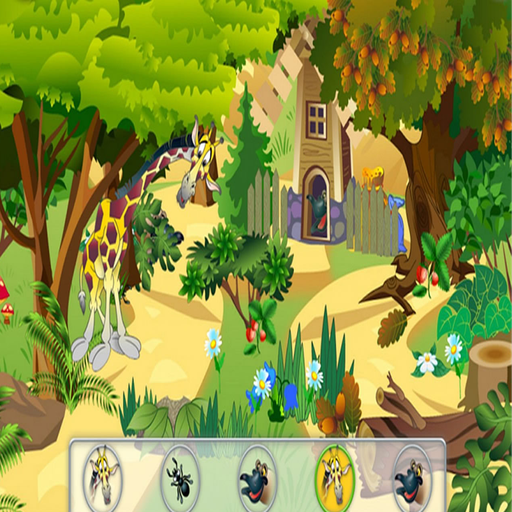

In [ ]:
max_size = 512

# Calculate the scaling factor to fit within the specified maximum size
scale_factor = max_size / max(img.size)

# Calculate the new dimensions
# new_size = tuple(int(dim * scale_factor) for dim in img.size)
new_size = tuple([max_size, max_size])

# Resize the image while preserving the aspect ratio
resized_img = img.resize(new_size, Image.ANTIALIAS)

resized_img

In [ ]:
rgb_resized_img = resized_img.convert("RGB")

In [ ]:
from torchvision import transforms

transform = transforms.ToTensor()

In [ ]:
tensor_img = transform(rgb_resized_img)
tensor_img.shape

torch.Size([3, 512, 512])

  0%|          | 0/100 [00:00<?, ?it/s]

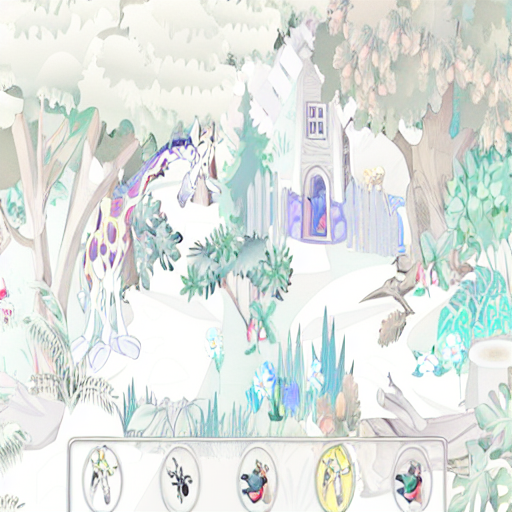

In [ ]:
images = pipe(
    "Make coloring book style with solid lines on edges and only white color",
    image=tensor_img,
    num_inference_steps=50,
    guidance_scale=7.5,
    image_guidance_scale=1.5,
    num_images_per_prompt=1
).images
images[0]

In [ ]:
import sys
import os
from tqdm import tqdm

In [ ]:
# make array with pathes of all files in /content/AbsKids
# /content/AbsKids/Kids/
# /content/AbsKidsText/Kids with text/
# /content/AbsOther/Other/
pathes = []
for root, dirs, files in os.walk("/content/AbsOther/content/AbsOther/Other/"):
    for name in files:
        pathes.append(os.path.join(root, name))

len(pathes)

47

In [ ]:
def resize_and_compose_images(image_path, output_path):
    temp_img = Image.open(image_path)

    max_size = 512

    # Calculate the scaling factor to fit within the specified maximum size
    scale_factor = 512 / max(temp_img.size)

    # Calculate the new dimensions
    # new_size = tuple(int(dim * scale_factor) for dim in img.size)
    new_size = tuple(int(dim * scale_factor) for dim in temp_img.size)

    # Resize the image while preserving the aspect ratio
    resized_img = temp_img.resize(new_size, Image.ANTIALIAS)
    resized_img = resized_img.convert("RGB")

    transform = transforms.ToTensor()

    tensor_img = transform(resized_img)

    images = pipe(
        "Make coloring book style with solid lines on edges and only white color",
        image=tensor_img,
        num_inference_steps=50,
        guidance_scale=7.5,
        image_guidance_scale=1.5,
        num_images_per_prompt=1
    ).images

    # # Save the result image
    images[0].save(output_path)

In [ ]:
!rm -rf /content/AbsKids/content/AbsKids/.ipynb_checkpoints

In [ ]:
# /content/AbsKids/Img2LineKids/
# /content/AbsKidsText/Img2LineKidsText/
# /content/AbsOther/Img2LineOther/

for i, path in tqdm(enumerate(pathes)):
    img_name = path.split('/')[-1]
    resize_and_compose_images(path, f"/content/AbsOther/content/AbsOther/InstuctPix2PixOther/{img_name}")

In [ ]:
!zip -r /content/AbsKidsTransformed.zip /content/AbsKids/

!zip -r /content/AbsKidsTextTransformed.zip /content/AbsKidsText/

!zip -r /content/AbsOtherTransformed.zip /content/AbsOther/

In [ ]:
!cp /content/AbsKidsTransformed.zip /content/drive/MyDrive/datasets
!cp /content/AbsKidsTextTransformed.zip /content/drive/MyDrive/datasets
!cp /content/AbsOtherTransformed.zip /content/drive/MyDrive/datasets